In [1]:
import time
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import dgl
import networkx as nx
import torch
import torch.nn as nn

import utils
from gsp_utils.baselines_archs import GCNN_2L
from gsp_utils.baselines_models import NodeClassModel, GF_NodeClassModel
from gsp_utils.data import normalize_gso
from src.arch import GFGCN, GFGCNLayer, GFGCN_noh_Layer, GFGCN_Spows, Dual_GFGCN

SEED = 15
# PATH = 'results/diff_filters/'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

torch.manual_seed(SEED)

cuda:0


In [2]:
# Auxiliary functions
def summary_table(acc, index_name):
    mean_accs = acc.mean(axis=1)
    med_accs = np.median(acc, axis=1)
    std_accs = acc.std(axis=1)
    return DataFrame(np.vstack((mean_accs, med_accs, std_accs)).T, columns=['mean accs', 'med', 'std'], index=index_name)

In [3]:
# Dataset must be from DGL
dataset_name = 'WisconsinDataset'

A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device,
                                                     verb=True)
N = A.shape[0]

/home/srey/Investigacion/robust_minmax_gnn/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Dataset: WisconsinDataset
Number of nodes: 251
Number of features: 1703
Shape of signals: torch.Size([251, 1703])
Number of classes: 5
Norm of A: 22.69361114501953
Max value of A: 1.0
Proportion of validation data: 0.32
Proportion of test data: 0.20
Node homophily: 0.13
Edge homophily: 0.20


# Without normalizing the GSO

In [4]:
# BEST PARAMETERS (Alpha: None) -  0.89
## Training params
N_RUNS = 10
N_EPOCHS = 200
EPOCHS_h = 50  # 100
EPOCHS_W = 25  # 10
LR = .005
WD = .001
DROPOUT = .25
ALPHA = .8  # .7 also works

# BEST PARAMETERS
## Architecture params
N_LAYERS = 2
K = 3
HID_DIM = 32
BIAS = True

## Model params
h0 = 1
NORM = False

IN_DIM = feat.shape[1]
OUT_DIM = n_class

ACT = nn.ReLU() 
LAST_ACT = nn.Softmax(dim=1)
LOSS_FN = nn.CrossEntropyLoss()


# # BEST PARAMETERS (Alpha: None) -  0.88
# ## Training params
# N_RUNS = 10
# N_EPOCHS = 200
# EPOCHS_h = 50  # 25
# EPOCHS_W = 25  # 25
# LR = .005
# WD = .001
# DROPOUT = .25
# ALPHA = None  # .7

# # BEST PARAMETERS
# ## Architecture params
# N_LAYERS = 2
# K = 3
# HID_DIM = 32  # 64

# ## Model params
# h0 = 1  # 1
# NORM = False

# IN_DIM = feat.shape[1]
# OUT_DIM = n_class

# ACT = nn.ReLU() 
# LAST_ACT = nn.Softmax(dim=1)
# LOSS_FN = nn.CrossEntropyLoss()

## Plotting eval/test acc/loss

In [5]:
# Parameters
epochs = N_EPOCHS
epochs_h = EPOCHS_h
epochs_W = EPOCHS_W
lr =  LR
wd = WD
drop = DROPOUT
L = N_LAYERS
K_aux = K
hid_dim = HID_DIM
h0_aux = 1
norm = False
act = ACT
lact = LAST_ACT
loss_fn = LOSS_FN
patience = 200
bias = True
alpha = None #ALPHA

iters_aux = 1

err1 = np.zeros(iters_aux)
err2 = np.zeros(iters_aux)
for i in range(iters_aux):

    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)

    # Create model
    arch = Dual_GFGCN(IN_DIM, hid_dim, OUT_DIM, L, K_aux, alpha=alpha,
                       act=act, last_act=lact, dropout=drop, init_h0=h0_aux, bias=bias)
    S = torch.Tensor(A).to(device)
    model = GF_NodeClassModel(arch, S, K, masks, loss_fn, device=device)
    loss, acc = model.train(feat, labels, epochs, lr, wd, epochs_h=epochs_h, epochs_W=epochs_W,
                            patience=patience)

    idx_max_acc = np.argmax(acc["val"])
    print(f'Best val acc: {acc["val"][idx_max_acc]:.3f}  -  Best test acc: {np.max(acc["test"]):.3f}')
    print(f'Test acc at best val: {acc["test"][idx_max_acc]:.3f}')

    acc_val = model.test(feat, S, labels, masks['val'])
    acc_test = model.test(feat, S, labels, masks['test'])
    print(f'Val acc: {acc_val:.3f}  -  Test acc: {acc_test:.3f}')

    err1[i] = acc["test"][idx_max_acc]
    err2[i] = acc_test

    print(arch.alpha)

KeyboardInterrupt: 

In [ ]:
arch.alpha

Parameter containing:
tensor([1.], device='cuda:1', requires_grad=True)

Acc at best val acc: 0.863 +- 0.000
Acc at test: 0.863 +- 0.000


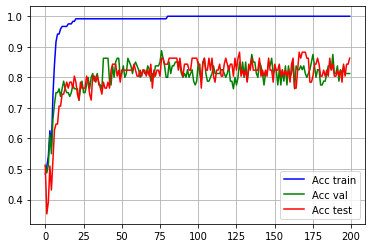

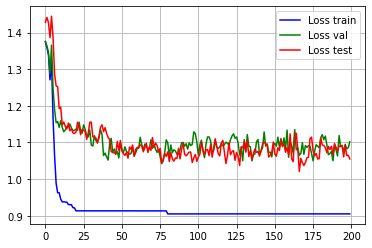

In [ ]:
print(f'Acc at best val acc: {err1.mean():.3f} +- {err1.std():.3f}')
print(f'Acc at test: {err2.mean():.3f} +- {err1.std():.3f}')

# Plot
plt.figure(figsize=[6,4])
plt.plot(acc['train'], 'b-', label='Acc train')
plt.plot(acc['val'], 'g-', label='Acc val')
plt.plot(acc['test'], 'r-', label='Acc test')
plt.grid()
plt.legend()

plt.figure(figsize=[6,4])
plt.plot(loss['train'], 'b-', label='Loss train')
plt.plot(loss['val'], 'g-', label='Loss val')
plt.plot(loss['test'], 'r-', label='Loss test')
plt.grid()
plt.legend()

## Training paramerters

In [ ]:
EXPS = [
        # {'epochs': 200, 'lr': .001, 'wd': 1e-4, 'drop': .25},
        # {'epochs': 200, 'lr': .001, 'wd': 5e-4, 'drop': .25},
        # {'epochs': 200, 'lr': .001, 'wd': 1e-3, 'drop': .25},
        # {'epochs': 200, 'lr': .001, 'wd': 5e-3, 'drop': .25},
        {'epochs': 200, 'lr': .001, 'wd': 1e-2, 'drop': .25},

        # {'epochs': 200, 'lr': .005, 'wd': 1e-4, 'drop': .25},
        {'epochs': 200, 'lr': .005, 'wd': 5e-4, 'drop': .25},
        {'epochs': 200, 'lr': .005, 'wd': 1e-3, 'drop': .25}, # .866
        {'epochs': 200, 'lr': .005, 'wd': 5e-3, 'drop': .25},

        # {'epochs': 200, 'lr': .01, 'wd': 1e-4, 'drop': .25},
        {'epochs': 200, 'lr': .01, 'wd': 1e-3, 'drop': .25},
        {'epochs': 200, 'lr': .01, 'wd': 5e-3, 'drop': .25},
        {'epochs': 200, 'lr': .01, 'wd': 1e-2, 'drop': .25},

        # {'epochs': 10, 'lr': .001, 'wd': 5e-3, 'drop': .25},
        # {'epochs': 50, 'lr': .001, 'wd': 5e-3, 'drop': .25},
        {'epochs': 500, 'lr': .005, 'wd': 1e-3, 'drop': .25},
        {'epochs': 750, 'lr': .005, 'wd': 1e-3, 'drop': .25},
        # {'epochs': 10, 'lr': .005, 'wd': 5e-3, 'drop': .25},
        {'epochs': 50, 'lr': .01, 'wd': 1e-3, 'drop': .25},
        {'epochs': 500, 'lr': .01, 'wd': 1e-3, 'drop': .25},
        {'epochs': 750, 'lr': .01, 'wd': 1e-3, 'drop': .25},

        # {'epochs': 200, 'lr': .005, 'wd': 1e-3, 'drop': 0},
        {'epochs': 200, 'lr': .005, 'wd': 1e-3, 'drop': .5}, 
        {'epochs': 200, 'lr': .005, 'wd': 1e-3, 'drop': .75},
        # {'epochs': 200, 'lr': .01, 'wd': 5e-3, 'drop': 0},
        {'epochs': 200, 'lr': .01, 'wd': 5e-3, 'drop': .5},
        {'epochs': 200, 'lr': .01, 'wd': 5e-3, 'drop': .75},

        {'epochs': 500, 'lr': .005, 'wd': 1e-3, 'drop': .5},  # .87
        {'epochs': 750, 'lr': .005, 'wd': 1e-3, 'drop': .5},
        {'epochs': 500, 'lr': .005, 'wd': 5e-4, 'drop': .5},
        {'epochs': 500, 'lr': .01, 'wd': 5e-3, 'drop': .5},
        ]

best_accs1 = np.zeros((len(EXPS), N_RUNS))
best_val_accs1 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = Dual_GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, alpha=ALPHA,
                          last_act=LAST_ACT, dropout=exp['drop'], init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S, K, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, exp['epochs'], exp['lr'], exp['wd'],
                             epochs_h=EPOCHS_h, epochs_W=EPOCHS_W)

        best_accs1[j,i] = np.max(acc["test"])
        best_val_accs1[j,i] = model.test(feat, S, labels, masks['test'])

        print(f'-{i+1}: {exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}: {best_val_accs1[j,i]:.3f} ({best_accs1[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}' for exp in EXPS]
table_over1 = summary_table(best_accs1, index_name)
table1 = summary_table(best_val_accs1, index_name)



-1: 200-0.001-0.01-0.25: 0.745 (0.804)
-1: 200-0.005-0.0005-0.25: 0.824 (0.863)
-1: 200-0.005-0.001-0.25: 0.863 (0.882)
-1: 200-0.005-0.005-0.25: 0.804 (0.863)
-1: 200-0.01-0.001-0.25: 0.843 (0.902)
-1: 200-0.01-0.005-0.25: 0.824 (0.863)
-1: 200-0.01-0.01-0.25: 0.882 (0.882)
-1: 500-0.005-0.001-0.25: 0.843 (0.902)
-1: 750-0.005-0.001-0.25: 0.824 (0.882)
-1: 50-0.01-0.001-0.25: 0.804 (0.843)
-1: 500-0.01-0.001-0.25: 0.863 (0.882)
-1: 750-0.01-0.001-0.25: 0.843 (0.902)
-1: 200-0.005-0.001-0.5: 0.843 (0.863)
-1: 200-0.005-0.001-0.75: 0.745 (0.843)
-1: 200-0.01-0.005-0.5: 0.804 (0.882)
-1: 200-0.01-0.005-0.75: 0.804 (0.863)
-1: 500-0.005-0.001-0.5: 0.804 (0.882)
-1: 750-0.005-0.001-0.5: 0.784 (0.863)
-1: 500-0.005-0.0005-0.5: 0.843 (0.882)
-1: 500-0.01-0.005-0.5: 0.863 (0.882)
-2: 200-0.001-0.01-0.25: 0.882 (0.922)
-2: 200-0.005-0.0005-0.25: 0.863 (0.922)
-2: 200-0.005-0.001-0.25: 0.863 (0.902)
-2: 200-0.005-0.005-0.25: 0.863 (0.922)
-2: 200-0.01-0.001-0.25: 0.882 (0.922)
-2: 200-0.01-0.00

In [ ]:
table1


,mean accs,med,std
200-0.001-0.01-0.25,0.827451,0.833333,0.053913
200-0.005-0.0005-0.25,0.852941,0.862745,0.045775
200-0.005-0.001-0.25,0.858824,0.862745,0.031373
200-0.005-0.005-0.25,0.847059,0.833333,0.047059
200-0.01-0.001-0.25,0.854902,0.862745,0.025110
200-0.01-0.005-0.25,0.850980,0.852941,0.034187
200-0.01-0.01-0.25,0.858824,0.843137,0.032575
500-0.005-0.001-0.25,0.856863,0.852941,0.030440
750-0.005-0.001-0.25,0.852941,0.862745,0.050564
50-0.01-0.001-0.25,0.825490,0.823529,0.026956


## Model params

In [ ]:
EXPS = [
        # {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': False},
        # {'h0': 1, 'epochs': 1000, 'epochs_h': 1, 'epochs_W': 1, 'alt': False},
                
        # {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        # {'h0': 1, 'epochs': 2000, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        # {'h0': 1, 'epochs': 200, 'epochs_h': 10, 'epochs_W': 1, 'alt': True},
        # {'h0': 1, 'epochs': 200, 'epochs_h': 25, 'epochs_W': 1, 'alt': True},
        # {'h0': 1, 'epochs': 200, 'epochs_h': 50, 'epochs_W': 1, 'alt': True},
        # {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 10, 'alt': True},
        # {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 25, 'alt': True},

        {'h0': 1, 'epochs': 200, 'epochs_h': 10, 'epochs_W': 5, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 25, 'epochs_W': 5, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 50, 'epochs_W': 5, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 25, 'epochs_W': 10, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 50, 'epochs_W': 25, 'alt': True},  # .88!
        {'h0': 1, 'epochs': 200, 'epochs_h': 75, 'epochs_W': 25, 'alt': True},
        # {'h0': 1, 'epochs': 200, 'epochs_h': 5, 'epochs_W': 10, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 5, 'epochs_W': 25, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 5, 'epochs_W': 50, 'alt': True},   # .88!
        
        # {'h0': .1, 'epochs': 200, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},

        {'h0': 1, 'epochs': 50, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},
        {'h0': 1, 'epochs': 50, 'epochs_h': 50, 'epochs_W': 25, 'alt': True},
        # {'h0': 1, 'epochs': 100, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},
        {'h0': 1, 'epochs': 100, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},
        {'h0': 1, 'epochs': 100, 'epochs_h': 50, 'epochs_W': 25, 'alt': True},
        # {'h0': 1, 'epochs': 100, 'epochs_h': 50, 'epochs_W': 50, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},  # .87
        # {'h0': 1, 'epochs': 200, 'epochs_h': 50, 'epochs_W': 50, 'alt': True},
        {'h0': 1, 'epochs': 500, 'epochs_h': 50, 'epochs_W': 25, 'alt': True},
    ]


best_accs2 = np.zeros((len(EXPS), N_RUNS))
best_val_accs2 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = Dual_GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, alpha=ALPHA,
                          last_act=LAST_ACT, dropout=DROPOUT, init_h0=exp['h0'])
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        if not exp['alt']:
            model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
            _, acc = model.train(feat, labels, exp['epochs'], LR, WD)
        else:
            model = GF_NodeClassModel(arch, S,  K, masks, LOSS_FN, device=device)
            _, acc = model.train(feat, labels, exp['epochs'], LR, WD, epochs_h=exp['epochs_h'],
                                 epochs_W=exp['epochs_W'])

        best_accs2[j,i] = np.max(acc["test"])
        best_val_accs2[j,i] = model.test(feat, S, labels, masks['test'])

        print(f'-{i+1}: {exp["h0"]}-{exp["epochs"]}-{exp["epochs_h"]}-{exp["epochs_W"]}-{exp["alt"]}: {best_val_accs2[j,i]:.3f} ({best_accs2[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["epochs"]}-{exp["h0"]}-{exp["epochs_h"]}-{exp["epochs_W"]}-{exp["alt"]}' for exp in EXPS]
table_over2 = summary_table(best_accs2, index_name)
table2 = summary_table(best_val_accs2, index_name)

-1: 1-200-10-5-True: 0.863 (0.863)
-1: 1-200-25-5-True: 0.824 (0.843)
-1: 1-200-50-5-True: 0.863 (0.882)
-1: 1-200-25-10-True: 0.824 (0.863)


KeyboardInterrupt: 

In [ ]:
table2

,mean accs,med,std
200-1-10-5-True,0.833333,0.852941,0.053519
200-1-25-5-True,0.852941,0.862745,0.036420
200-1-50-5-True,0.841176,0.852941,0.045098
200-1-25-10-True,0.835294,0.852941,0.046566
200-1-50-25-True,0.860784,0.843137,0.045098
200-1-75-25-True,0.843137,0.843137,0.042054
200-1-5-25-True,0.798039,0.823529,0.107772
200-1-5-50-True,0.831373,0.862745,0.132755
50-1-25-25-True,0.825490,0.813725,0.056456
50-1-50-25-True,0.835294,0.852941,0.048980


## Alpha

In [ ]:
# h0, norm (norm, not norm, norm H), sep vs joint training, optimizers iters (W vs h)
EXPS = [
        # {'alpha': 0},
        {'alpha': .25},
        # {'alpha': .4},
        {'alpha': .5},
        {'alpha': .6},
        {'alpha': .7},  # .87
        {'alpha': .8},  # .87
        {'alpha': 1},
        {'alpha': None},
    ]


best_accs2b = np.zeros((len(EXPS), N_RUNS))
best_val_accs2b = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = Dual_GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, alpha=exp['alpha'],
                          last_act=LAST_ACT, dropout=DROPOUT, init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S,  K, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h,
                              epochs_W=EPOCHS_W)

        best_accs2b[j,i] = np.max(acc["test"])
        best_val_accs2b[j,i] = model.test(feat, S, labels, masks['test'])

        print(f'-{i+1}: {exp["alpha"]}: {best_val_accs2b[j,i]:.3f} ({best_accs2b[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["alpha"]}' for exp in EXPS]
table_over2b = summary_table(best_accs2b, index_name)
table2b = summary_table(best_val_accs2b, index_name)

-1: 0.25: 0.824 (0.882)
-1: 0.5: 0.843 (0.863)
-1: 0.6: 0.784 (0.902)
-1: 0.7: 0.804 (0.863)
-1: 0.8: 0.882 (0.882)
-1: 1: 0.882 (0.882)
-1: None: 0.843 (0.882)
-2: 0.25: 0.824 (0.922)
-2: 0.5: 0.922 (0.922)
-2: 0.6: 0.824 (0.941)
-2: 0.7: 0.882 (0.902)
-2: 0.8: 0.922 (0.941)
-2: 1: 0.804 (0.941)
-2: None: 0.824 (0.922)
-3: 0.25: 0.843 (0.961)
-3: 0.5: 0.941 (0.941)
-3: 0.6: 0.863 (0.941)
-3: 0.7: 0.882 (0.941)
-3: 0.8: 0.882 (0.922)
-3: 1: 0.843 (0.922)
-3: None: 0.843 (0.922)
-4: 0.25: 0.863 (0.941)
-4: 0.5: 0.922 (0.961)
-4: 0.6: 0.941 (0.961)
-4: 0.7: 0.941 (0.961)
-4: 0.8: 0.922 (0.961)
-4: 1: 0.863 (0.941)
-4: None: 0.863 (0.941)
-5: 0.25: 0.902 (0.941)
-5: 0.5: 0.882 (0.922)
-5: 0.6: 0.902 (0.941)
-5: 0.7: 0.824 (0.922)
-5: 0.8: 0.902 (0.922)
-5: 1: 0.941 (0.941)
-5: None: 0.882 (0.941)
-6: 0.25: 0.824 (0.882)
-6: 0.5: 0.882 (0.902)
-6: 0.6: 0.863 (0.922)
-6: 0.7: 0.902 (0.922)
-6: 0.8: 0.863 (0.922)
-6: 1: 0.863 (0.902)
-6: None: 0.824 (0.902)
-7: 0.25: 0.824 (0.882)
-7: 0.5: 0

In [ ]:
table2b

,mean accs,med,std
0.25,0.835294,0.823529,0.028006
0.5,0.882353,0.882353,0.038223
0.6,0.862745,0.862745,0.047222
0.7,0.872549,0.882353,0.038473
0.8,0.890196,0.892157,0.026597
1,0.864706,0.862745,0.039654
None,0.845098,0.843137,0.022270


## Architecture design - Bias True

In [ ]:
# layers, filter order, weightd
EXPS = [{'L': 2, 'K': 2, 'hid_dim': 16},
        {'L': 2, 'K': 2, 'hid_dim': 32},
        {'L': 2, 'K': 2, 'hid_dim': 64},

        # {'L': 2, 'K': 3, 'hid_dim': 8},
        {'L': 2, 'K': 3, 'hid_dim': 16},
        {'L': 2, 'K': 3, 'hid_dim': 32},
        {'L': 2, 'K': 3, 'hid_dim': 64},
        {'L': 2, 'K': 3, 'hid_dim': 128},

        # {'L': 2, 'K': 4, 'hid_dim': 16},

        # {'L': 3, 'K': 2, 'hid_dim': 8},
        {'L': 3, 'K': 2, 'hid_dim': 16},
        {'L': 3, 'K': 2, 'hid_dim': 32},
        {'L': 3, 'K': 2, 'hid_dim': 64},

        # {'L': 4, 'K': 2, 'hid_dim': 16},
        # {'L': 3, 'K': 3, 'hid_dim': 16},
        ]

best_accs3 = np.zeros((len(EXPS), N_RUNS))
best_val_accs3 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = Dual_GFGCN(IN_DIM, exp['hid_dim'], OUT_DIM, exp['L'], exp['K'], act=ACT, alpha=ALPHA,
                          last_act=LAST_ACT, dropout=DROPOUT, init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S,  exp['K'], masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h,
                              epochs_W=EPOCHS_W)

        best_accs3[j,i] = np.max(acc["test"])
        best_val_accs3[j,i] = model.test(feat, S, labels, masks['test'])

        print(f'-{i+1}: {exp["L"]}-{exp["K"]}-{exp["hid_dim"]}: {best_val_accs3[j,i]:.3f} ({best_accs3[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["L"]}-{exp["K"]}-{exp["hid_dim"]}' for exp in EXPS]
table_over3 = summary_table(best_accs3, index_name)
table3 = summary_table(best_val_accs3, index_name)

-1: 2-2-16: 0.824 (0.902)
-1: 2-2-32: 0.863 (0.882)
-1: 2-2-64: 0.824 (0.882)
-1: 2-3-16: 0.765 (0.843)
-1: 2-3-32: 0.863 (0.882)
-1: 2-3-64: 0.843 (0.882)
-1: 2-3-128: 0.824 (0.843)
-1: 3-2-16: 0.569 (0.647)
-1: 3-2-32: 0.863 (0.882)
-1: 3-2-64: 0.824 (0.863)
-2: 2-2-16: 0.902 (0.902)
-2: 2-2-32: 0.824 (0.922)
-2: 2-2-64: 0.863 (0.922)
-2: 2-3-16: 0.804 (0.902)
-2: 2-3-32: 0.902 (0.922)
-2: 2-3-64: 0.843 (0.922)
-2: 2-3-128: 0.863 (0.922)
-2: 3-2-16: 0.863 (0.922)
-2: 3-2-32: 0.882 (0.902)
-2: 3-2-64: 0.863 (0.922)
-3: 2-2-16: 0.706 (0.784)
-3: 2-2-32: 0.863 (0.941)
-3: 2-2-64: 0.843 (0.941)
-3: 2-3-16: 0.804 (0.843)
-3: 2-3-32: 0.843 (0.941)
-3: 2-3-64: 0.863 (0.941)
-3: 2-3-128: 0.843 (0.922)
-3: 3-2-16: 0.824 (0.843)
-3: 3-2-32: 0.902 (0.922)
-3: 3-2-64: 0.882 (0.941)
-4: 2-2-16: 0.784 (0.804)
-4: 2-2-32: 0.882 (0.941)
-4: 2-2-64: 0.882 (0.922)
-4: 2-3-16: 0.863 (0.902)
-4: 2-3-32: 0.902 (0.941)
-4: 2-3-64: 0.902 (0.941)
-4: 2-3-128: 0.863 (0.922)
-4: 3-2-16: 0.510 (0.588)
-4: 3-2-

In [ ]:
table3

,mean accs,med,std
2-2-16,0.809804,0.813725,0.054797
2-2-32,0.856863,0.862745,0.023283
2-2-64,0.852941,0.852941,0.020092
2-3-16,0.805882,0.803922,0.034467
2-3-32,0.858824,0.862745,0.033735
2-3-64,0.862745,0.862745,0.031617
2-3-128,0.847059,0.843137,0.032575
3-2-16,0.733333,0.784314,0.127737
3-2-32,0.870588,0.872549,0.028006
3-2-64,0.850980,0.852941,0.034187


## GSO, bias, and batch norm

In [ ]:
EXPS = [{'GSO': 'orig', 'bias': True, 'bn': False},
        {'GSO': 'orig', 'bias': True, 'bn': True},
        {'GSO': 'orig', 'bias': False, 'bn': True},
        {'GSO': 'orig', 'bias': False, 'bn': False},
        ]

best_accs3b = np.zeros((len(EXPS), N_RUNS))
best_val_accs3b = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = Dual_GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, alpha=ALPHA, act=ACT, last_act=LAST_ACT,
                     dropout=DROPOUT, init_h0=h0, bias=exp['bias'], batch_norm=exp['bn'])
        
        if exp['GSO'] == 'sym':
            A_aux = (A + A.T)/2
            A_aux = np.where(A_aux > 0, 1, 0)
        elif exp['GSO'] == 'trans':
            A_aux = A.T
        else:
            A_aux = A

        if NORM:
            S = torch.Tensor(normalize_gso(A_aux, 'both')).to(device)
        else:
            S = torch.Tensor(A_aux).to(device)

        model = GF_NodeClassModel(arch, S,  K, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h,
                              epochs_W=EPOCHS_W)

        best_accs3b[j,i] = np.max(acc["test"])
        best_val_accs3b[j,i] = model.test(feat, S, labels, masks['test'])

        print(f'- {i+1}: {exp["GSO"]}-{exp["bias"]}-{exp["bn"]}: {best_val_accs3b[j,i]:.3f} ({best_accs3b[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["GSO"]}-{exp["bias"]}-{exp["bn"]}' for exp in EXPS]
table_over3b = summary_table(best_accs3b, index_name)
table3b = summary_table(best_val_accs3b, index_name)

- 1: orig-True-False: 0.843 (0.863)
- 1: orig-True-True: 0.569 (0.843)
- 1: orig-False-False: 0.824 (0.882)
- 2: orig-True-False: 0.863 (0.882)
- 2: orig-True-True: 0.745 (0.784)
- 2: orig-False-False: 0.843 (0.882)
- 3: orig-True-False: 0.863 (0.902)
- 3: orig-True-True: 0.804 (0.863)
- 3: orig-False-False: 0.882 (0.922)
- 4: orig-True-False: 0.882 (0.961)
- 4: orig-True-True: 0.863 (0.941)
- 4: orig-False-False: 0.941 (0.961)
- 5: orig-True-False: 0.902 (0.922)
- 5: orig-True-True: 0.824 (0.863)
- 5: orig-False-False: 0.843 (0.922)
- 6: orig-True-False: 0.843 (0.882)
- 6: orig-True-True: 0.804 (0.843)
- 6: orig-False-False: 0.882 (0.882)
- 7: orig-True-False: 0.882 (0.882)
- 7: orig-True-True: 0.824 (0.882)
- 7: orig-False-False: 0.843 (0.863)
- 8: orig-True-False: 0.784 (0.882)
- 8: orig-True-True: 0.824 (0.882)
- 8: orig-False-False: 0.843 (0.902)
- 9: orig-True-False: 0.784 (0.863)
- 9: orig-True-True: 0.882 (0.882)
- 9: orig-False-False: 0.843 (0.863)
- 10: orig-True-False: 0.863

In [ ]:
table3b

,mean accs,med,std
orig-True-False,0.850980,0.862745,0.037409
orig-True-True,0.800000,0.823529,0.085379
orig-False-False,0.866667,0.843137,0.036996


## Nonlinearities and loss function

In [ ]:
# layers, filter order, weightd
EXPS = [{'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        # {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        # {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.NLLLoss()},
        # {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},
        # {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        # {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        # {'act': nn.LeakyReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        # {'act': nn.Identity(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},
        ]

best_accs4 = np.zeros((len(EXPS), N_RUNS))
best_val_accs4 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = Dual_GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, alpha=ALPHA, act=exp['act'],
                          last_act=exp['lact'], dropout=DROPOUT, init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S,  K, masks, exp['loss'], device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h,
                              epochs_W=EPOCHS_W)

        best_accs4[j,i] = np.max(acc["test"])
        best_val_accs4[j,i] = model.test(feat, S, labels, masks['test'])

        print(f'-{i+1}: {exp["act"]}-{exp["lact"]}-{exp["loss"]}: {best_val_accs4[j,i]:.3f} ({best_accs4[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["act"]}-{exp["lact"]}-{exp["loss"]}' for exp in EXPS]
table_over4 = summary_table(best_accs4, index_name)
table4 = summary_table(best_val_accs4, index_name)

-1: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.824 (0.843)
-1: ReLU()-Softmax(dim=1)-NLLLoss(): 0.804 (0.863)
-1: ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(): 0.784 (0.804)
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(): 0.804 (0.863)
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(): 0.843 (0.863)
-1: Identity()-Softmax(dim=1)-CrossEntropyLoss(): 0.804 (0.863)
-1: Identity()-Softmax(dim=1)-NLLLoss(): 0.843 (0.843)
-2: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.843 (0.882)
-2: ReLU()-Softmax(dim=1)-NLLLoss(): 0.843 (0.882)
-2: ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(): 0.902 (0.922)
-2: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(): 0.843 (0.863)
-2: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(): 0.882 (0.882)
-2: Identity()-Softmax(dim=1)-CrossEntropyLoss(): 0.902 (0.922)
-2: Identity()-Softmax(dim=1)-NLLLoss(): 0.863 (0.882)
-3: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.882 (0.922)
-3: ReLU()-Softmax(dim=1)-

In [ ]:
table4

,mean accs,med,std
ReLU()-Softmax(dim=1)-CrossEntropyLoss(),0.868627,0.872549,0.026380
ReLU()-Softmax(dim=1)-NLLLoss(),0.833333,0.843137,0.036420
ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(),0.833333,0.823529,0.039460
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(),0.860784,0.862745,0.030941
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(),0.827451,0.833333,0.042779
Identity()-Softmax(dim=1)-CrossEntropyLoss(),0.839216,0.833333,0.031373
Identity()-Softmax(dim=1)-NLLLoss(),0.819608,0.823529,0.050221


# Normalizing the GSO

In [4]:
# BEST PARAMETERS  - .87
## Training params
N_RUNS = 10
N_EPOCHS = 200
EPOCHS_h = 25  # 10
EPOCHS_W = 25  # 10
LR = .005  # .01
WD = .005
DROPOUT = .25
ALPHA = .8  # .7

# BEST PARAMETERS
## Architecture params
N_LAYERS = 3
K = 2
HID_DIM = 32

## Model params
h0 = .1  # 1
NORM = True

IN_DIM = feat.shape[1]
OUT_DIM = n_class

ACT = nn.ReLU() 
LAST_ACT = nn.Softmax(dim=1)
LOSS_FN = nn.CrossEntropyLoss()


# # BEST PARAMETERS  - 
# ## Training params
# N_RUNS = 10
# N_EPOCHS = 200
# EPOCHS_h = 10  # 25
# EPOCHS_W = 10  # 25
# LR = .005
# WD = .001
# DROPOUT = .25
# ALPHA = None  # .7

# # BEST PARAMETERS
# ## Architecture params
# N_LAYERS = 2
# K = 3
# HID_DIM = 32  # 64

# ## Model params
# h0 = 1  # 1
# NORM = True

# IN_DIM = feat.shape[1]
# OUT_DIM = n_class

# ACT = nn.ReLU() 
# LAST_ACT = nn.Softmax(dim=1)
# LOSS_FN = nn.CrossEntropyLoss()

## Training paramerters

In [5]:
EXPS = [
        {'epochs': 200, 'lr': .005, 'wd': 1e-4, 'drop': .25},
        {'epochs': 200, 'lr': .005, 'wd': 5e-4, 'drop': .25},

        {'epochs': 200, 'lr': .01, 'wd': 1e-3, 'drop': .25},
        {'epochs': 200, 'lr': .005, 'wd': 1e-3, 'drop': .25},
        {'epochs': 200, 'lr': .005, 'wd': 1e-3, 'drop': .5},
        {'epochs': 200, 'lr': .001, 'wd': 1e-3, 'drop': .25},

        {'epochs': 200, 'lr': .01, 'wd': 5e-3, 'drop': .25},
        {'epochs': 200, 'lr': .005, 'wd': 5e-3, 'drop': .25},
        {'epochs': 200, 'lr': .001, 'wd': 5e-3, 'drop': .25},
        
        {'epochs': 200, 'lr': .005, 'wd': 1e-2, 'drop': .25},

        {'epochs': 500, 'lr': .01, 'wd': 1e-3, 'drop': .25},
        {'epochs': 500, 'lr': .005, 'wd': 1e-3, 'drop': .25},
        {'epochs': 500, 'lr': .001, 'wd': 1e-3, 'drop': .25},

        {'epochs': 500, 'lr': .005, 'wd': 5e-3, 'drop': .25},
        {'epochs': 500, 'lr': .001, 'wd': 5e-3, 'drop': .25},


        {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': .5},
        {'epochs': 200, 'lr': .05, 'wd': 5e-3, 'drop': .5},
        {'epochs': 200, 'lr': .01, 'wd': 5e-3, 'drop': .5},
        {'epochs': 200, 'lr': .05, 'wd': 1e-2, 'drop': 0},
        {'epochs': 200, 'lr': .05, 'wd': 5e-3, 'drop': 0},
        {'epochs': 200, 'lr': .01, 'wd': 5e-3, 'drop': 0},

        
        {'epochs': 500, 'lr': .005, 'wd': 5e-3, 'drop': .5},
        {'epochs': 500, 'lr': .005, 'wd': 1e-3, 'drop': .5},
        {'epochs': 500, 'lr': .001, 'wd': 1e-3, 'drop': .5},

        {'epochs': 750, 'lr': .005, 'wd': 5e-3, 'drop': .25},
        {'epochs': 750, 'lr': .005, 'wd': 1e-3, 'drop': .25},
        {'epochs': 750, 'lr': .001, 'wd': 1e-3, 'drop': .25},
        ]

best_accs5 = np.zeros((len(EXPS), N_RUNS))
best_val_accs5 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i)
    for j, exp in enumerate(EXPS):
        arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                     dropout=exp['drop'], init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S, K, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, exp['epochs'], exp['lr'], exp['wd'], epochs_h=EPOCHS_h,
                              epochs_W=EPOCHS_W)

        best_accs5[j,i] = np.max(acc["test"])
        best_val_accs5[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}: {best_val_accs5[j,i]:.3f} ({best_accs5[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}' for exp in EXPS]
table_over5 = summary_table(best_accs5, index_name)
table5 = summary_table(best_val_accs5, index_name)



/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:44: RuntimeWarning: divide by zero encountered in divide
  D_inv = np.diag(np.where(np.isclose(deg_vec, 0), 0, 1/deg_vec))


-1: 200-0.005-0.0001-0.25: 0.745 (0.784)
-1: 200-0.005-0.0005-0.25: 0.804 (0.863)
-1: 200-0.01-0.001-0.25: 0.804 (0.902)
-1: 200-0.005-0.001-0.25: 0.804 (0.863)
-1: 200-0.005-0.001-0.5: 0.706 (0.863)
-1: 200-0.001-0.001-0.25: 0.667 (0.706)
-1: 200-0.01-0.005-0.25: 0.843 (0.882)
-1: 200-0.005-0.005-0.25: 0.824 (0.863)
-1: 200-0.001-0.005-0.25: 0.784 (0.824)
-1: 200-0.005-0.01-0.25: 0.804 (0.863)
-1: 500-0.01-0.001-0.25: 0.863 (0.863)
-1: 500-0.005-0.001-0.25: 0.843 (0.863)
-1: 500-0.001-0.001-0.25: 0.784 (0.843)
-1: 500-0.005-0.005-0.25: 0.843 (0.882)
-1: 500-0.001-0.005-0.25: 0.824 (0.843)
-1: 200-0.05-0.01-0.5: 0.824 (0.882)
-1: 200-0.05-0.005-0.5: 0.784 (0.863)
-1: 200-0.01-0.005-0.5: 0.804 (0.863)
-1: 200-0.05-0.01-0: 0.804 (0.843)
-1: 200-0.05-0.005-0: 0.745 (0.863)
-1: 200-0.01-0.005-0: 0.804 (0.843)
-1: 500-0.005-0.005-0.5: 0.824 (0.882)
-1: 500-0.005-0.001-0.5: 0.824 (0.882)
-1: 500-0.001-0.001-0.5: 0.804 (0.843)
-1: 750-0.005-0.005-0.25: 0.804 (0.863)
-1: 750-0.005-0.001-0.25: 

In [6]:
table5

,mean accs,med,std
200-0.005-0.0001-0.25,0.825490,0.813725,0.047587
200-0.005-0.0005-0.25,0.850980,0.852941,0.039411
200-0.01-0.001-0.25,0.847059,0.852941,0.038021
200-0.005-0.001-0.25,0.854902,0.862745,0.025110
200-0.005-0.001-0.5,0.835294,0.852941,0.051281
200-0.001-0.001-0.25,0.709804,0.725490,0.063112
200-0.01-0.005-0.25,0.862745,0.862745,0.015188
200-0.005-0.005-0.25,0.860784,0.862745,0.030941
200-0.001-0.005-0.25,0.801961,0.784314,0.043359
200-0.005-0.01-0.25,0.850980,0.852941,0.034187


## Model params

In [6]:
# h0, norm (norm, not norm, norm H), sep vs joint training, optimizers iters (W vs h)
EXPS = [
        # {'h0': .001, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        {'h0': .01, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        {'h0': .1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        {'h0': 1, 'epochs': 1000, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        {'h0': 1, 'epochs': 1500, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},

        # {'h0': .1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': False},
        # {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': False},
        # {'h0': 1, 'epochs': 1000, 'epochs_h': 1, 'epochs_W': 1, 'alt': False},

        {'h0': 1, 'epochs': 200, 'epochs_h': 5, 'epochs_W': 1, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 10, 'epochs_W': 1, 'alt': True},
        # {'h0': 1, 'epochs': 200, 'epochs_h': 25, 'epochs_W': 1, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 10, 'epochs_W': 5, 'alt': True},

        {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 5, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 10, 'alt': True},
        # {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 25, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 5, 'epochs_W': 10, 'alt': True},
        
        {'h0': .1, 'epochs': 200, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},
        {'h0': 1, 'epochs': 500, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},
        {'h0': 1, 'epochs': 50, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},
        {'h0': 1, 'epochs': 100, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},
        {'h0': .1, 'epochs': 200, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 50, 'epochs_W': 50, 'alt': True},
    ]


best_accs6 = np.zeros((len(EXPS), N_RUNS))
best_val_accs6 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i)
    for j, exp in enumerate(EXPS):
        arch = Dual_GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, alpha=ALPHA, act=ACT, last_act=LAST_ACT,
                     dropout=DROPOUT, init_h0=exp['h0'])
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        if not exp['alt']:
            model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
            _, acc = model.train(feat, labels, exp['epochs'], LR, WD)
        else:
            model = GF_NodeClassModel(arch, S,  K, masks, LOSS_FN, device=device)
            _, acc = model.train(feat, labels, exp['epochs'], LR, WD, epochs_h=exp['epochs_h'],
                                 epochs_W=exp['epochs_W'])

        best_accs6[j,i] = np.max(acc["test"])
        best_val_accs6[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["h0"]}-{exp["epochs_h"]}-{exp["epochs_W"]}-{exp["alt"]}: {best_val_accs6[j,i]:.3f} ({best_accs6[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["epochs"]}-{exp["h0"]}-{exp["epochs_h"]}-{exp["epochs_W"]}-{exp["alt"]}' for exp in EXPS]
table_over6 = summary_table(best_accs6, index_name)
table6 = summary_table(best_val_accs6, index_name)

/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:44: RuntimeWarning: divide by zero encountered in divide
  D_inv = np.diag(np.where(np.isclose(deg_vec, 0), 0, 1/deg_vec))


-1: 0.01-1-1-True: 0.824 (0.824)
-1: 0.1-1-1-True: 0.784 (0.843)
-1: 1-1-1-True: 0.824 (0.843)
-1: 1-1-1-True: 0.824 (0.863)
-1: 1-1-1-True: 0.804 (0.843)
-1: 1-5-1-True: 0.824 (0.843)
-1: 1-10-1-True: 0.824 (0.863)
-1: 1-10-5-True: 0.824 (0.863)
-1: 1-1-5-True: 0.745 (0.824)
-1: 1-1-10-True: 0.824 (0.843)
-1: 1-5-10-True: 0.804 (0.882)
-1: 0.1-10-10-True: 0.804 (0.882)
-1: 1-10-10-True: 0.784 (0.863)
-1: 1-10-10-True: 0.804 (0.863)
-1: 1-25-25-True: 0.686 (0.843)
-1: 1-25-25-True: 0.804 (0.863)
-1: 0.1-25-25-True: 0.784 (0.863)
-1: 1-25-25-True: 0.804 (0.863)
-1: 1-50-50-True: 0.843 (0.863)
-2: 0.01-1-1-True: 0.863 (0.902)
-2: 0.1-1-1-True: 0.882 (0.902)
-2: 1-1-1-True: 0.863 (0.902)
-2: 1-1-1-True: 0.863 (0.902)
-2: 1-1-1-True: 0.863 (0.902)
-2: 1-5-1-True: 0.902 (0.922)
-2: 1-10-1-True: 0.863 (0.922)
-2: 1-10-5-True: 0.843 (0.902)
-2: 1-1-5-True: 0.882 (0.902)
-2: 1-1-10-True: 0.784 (0.902)
-2: 1-5-10-True: 0.863 (0.902)
-2: 0.1-10-10-True: 0.863 (0.922)
-2: 1-10-10-True: 0.843 (0.9

In [10]:
table6

,mean accs,med,std
200-0.01-1-1-True,0.839216,0.852941,0.049449
200-0.1-1-1-True,0.837255,0.833333,0.039265
200-1-1-1-True,0.852941,0.852941,0.029412
1000-1-1-1-True,0.856863,0.862745,0.040232
1500-1-1-1-True,0.849020,0.852941,0.023283
200-1-5-1-True,0.858824,0.862745,0.040942
200-1-10-1-True,0.831373,0.823529,0.028006
200-1-10-5-True,0.868627,0.872549,0.035130
200-1-1-5-True,0.841176,0.843137,0.029672
200-1-1-10-True,0.852941,0.852941,0.044063


## Alpha

In [5]:
# h0, norm (norm, not norm, norm H), sep vs joint training, optimizers iters (W vs h)
EXPS = [
        # {'alpha': 0},
        {'alpha': .25},
        # {'alpha': .4},
        {'alpha': .5},
        {'alpha': .6},
        {'alpha': .7},  # .87
        {'alpha': .8},  # .87
        {'alpha': .9},  # .87
        {'alpha': 1},
        {'alpha': None},
    ]


best_accs6b = np.zeros((len(EXPS), N_RUNS))
best_val_accs6b = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = Dual_GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, alpha=exp['alpha'],
                          last_act=LAST_ACT, dropout=DROPOUT, init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S,  K, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h,
                              epochs_W=EPOCHS_W)

        best_accs6b[j,i] = np.max(acc["test"])
        best_val_accs6b[j,i] = model.test(feat, S, labels, masks['test'])

        print(f'-{i+1}: {exp["alpha"]}: {best_val_accs6b[j,i]:.3f} ({best_accs6b[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["alpha"]}' for exp in EXPS]
table_over6b = summary_table(best_accs6b, index_name)
table6b = summary_table(best_val_accs6b, index_name)

/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:44: RuntimeWarning: divide by zero encountered in divide
  D_inv = np.diag(np.where(np.isclose(deg_vec, 0), 0, 1/deg_vec))


-1: 0.25: 0.843 (0.863)
-1: 0.5: 0.824 (0.843)
-1: 0.6: 0.824 (0.863)
-1: 0.7: 0.804 (0.843)
-1: 0.8: 0.824 (0.863)
-1: 0.9: 0.804 (0.863)
-1: 1: 0.843 (0.863)
-1: None: 0.824 (0.863)
-2: 0.25: 0.863 (0.902)
-2: 0.5: 0.863 (0.902)
-2: 0.6: 0.863 (0.902)
-2: 0.7: 0.863 (0.922)
-2: 0.8: 0.863 (0.922)
-2: 0.9: 0.843 (0.922)
-2: 1: 0.824 (0.922)
-2: None: 0.863 (0.922)
-3: 0.25: 0.902 (0.922)
-3: 0.5: 0.863 (0.922)
-3: 0.6: 0.863 (0.922)
-3: 0.7: 0.902 (0.922)
-3: 0.8: 0.863 (0.922)
-3: 0.9: 0.863 (0.941)
-3: 1: 0.882 (0.922)
-3: None: 0.863 (0.922)
-4: 0.25: 0.882 (0.941)
-4: 0.5: 0.882 (0.922)
-4: 0.6: 0.902 (0.922)
-4: 0.7: 0.902 (0.961)
-4: 0.8: 0.922 (0.961)
-4: 0.9: 0.922 (0.961)
-4: 1: 0.902 (0.961)
-4: None: 0.843 (0.941)
-5: 0.25: 0.863 (0.902)
-5: 0.5: 0.784 (0.882)
-5: 0.6: 0.882 (0.882)
-5: 0.7: 0.863 (0.902)
-5: 0.8: 0.882 (0.922)
-5: 0.9: 0.882 (0.922)
-5: 1: 0.863 (0.922)
-5: None: 0.922 (0.922)
-6: 0.25: 0.863 (0.902)
-6: 0.5: 0.882 (0.882)
-6: 0.6: 0.863 (0.882)
-6: 0.7: 0

In [6]:
table6b

,mean accs,med,std
0.25,0.858824,0.862745,0.030122
0.5,0.845098,0.862745,0.035565
0.6,0.856863,0.862745,0.026380
0.7,0.860784,0.862745,0.028347
0.8,0.864706,0.862745,0.034467
0.9,0.860784,0.862745,0.032159
1,0.852941,0.843137,0.023611
None,0.847059,0.862745,0.039992


## Architecture design

In [7]:
# layers, filter order, weightd
EXPS = [{'L': 2, 'K': 2, 'hid_dim': 16},
        {'L': 2, 'K': 3, 'hid_dim': 16},
        # {'L': 2, 'K': 4, 'hid_dim': 16},

        {'L': 3, 'K': 2, 'hid_dim': 16},
        # {'L': 4, 'K': 2, 'hid_dim': 16},
        {'L': 3, 'K': 3, 'hid_dim': 16},
        # {'L': 4, 'K': 3, 'hid_dim': 16},

        {'L': 2, 'K': 2, 'hid_dim': 32},
        {'L': 2, 'K': 2, 'hid_dim': 64},
        {'L': 2, 'K': 2, 'hid_dim': 128},

        {'L': 2, 'K': 3, 'hid_dim': 32},
        {'L': 2, 'K': 3, 'hid_dim': 64},
        {'L': 2, 'K': 3, 'hid_dim': 128},

        {'L': 3, 'K': 2, 'hid_dim': 32},
        {'L': 3, 'K': 2, 'hid_dim': 64},
        {'L': 3, 'K': 2, 'hid_dim': 128},
        ]

best_accs7 = np.zeros((len(EXPS), N_RUNS))
best_val_accs7 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i)
    for j, exp in enumerate(EXPS):
        arch = Dual_GFGCN(IN_DIM, exp['hid_dim'], OUT_DIM, exp['L'], exp['K'], alpha=ALPHA,act=ACT,
                          last_act=LAST_ACT, dropout=DROPOUT, init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S,  exp['K'], masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h,
                              epochs_W=EPOCHS_W)

        best_accs7[j,i] = np.max(acc["test"])
        best_val_accs7[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["L"]}-{exp["K"]}-{exp["hid_dim"]}: {best_val_accs7[j,i]:.3f} ({best_accs7[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["L"]}-{exp["K"]}-{exp["hid_dim"]}' for exp in EXPS]
table_over7 = summary_table(best_accs7, index_name)
table7 = summary_table(best_val_accs7, index_name)

/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:44: RuntimeWarning: divide by zero encountered in divide
  D_inv = np.diag(np.where(np.isclose(deg_vec, 0), 0, 1/deg_vec))


-1: 2-2-16: 0.824 (0.843)
-1: 2-3-16: 0.804 (0.863)
-1: 3-2-16: 0.804 (0.843)
-1: 3-3-16: 0.804 (0.863)
-1: 2-2-32: 0.824 (0.843)
-1: 2-2-64: 0.804 (0.863)
-1: 2-2-128: 0.804 (0.863)
-1: 2-3-32: 0.804 (0.863)
-1: 2-3-64: 0.804 (0.863)
-1: 2-3-128: 0.784 (0.863)
-1: 3-2-32: 0.824 (0.882)
-1: 3-2-64: 0.824 (0.863)
-1: 3-2-128: 0.804 (0.863)
-2: 2-2-16: 0.902 (0.922)
-2: 2-3-16: 0.882 (0.922)
-2: 3-2-16: 0.863 (0.902)
-2: 3-3-16: 0.902 (0.922)
-2: 2-2-32: 0.882 (0.922)
-2: 2-2-64: 0.843 (0.922)
-2: 2-2-128: 0.882 (0.922)
-2: 2-3-32: 0.882 (0.941)
-2: 2-3-64: 0.882 (0.922)
-2: 2-3-128: 0.882 (0.902)
-2: 3-2-32: 0.902 (0.922)
-2: 3-2-64: 0.902 (0.922)
-2: 3-2-128: 0.863 (0.922)
-3: 2-2-16: 0.902 (0.922)
-3: 2-3-16: 0.882 (0.941)
-3: 3-2-16: 0.882 (0.941)
-3: 3-3-16: 0.843 (0.902)
-3: 2-2-32: 0.863 (0.922)
-3: 2-2-64: 0.882 (0.922)
-3: 2-2-128: 0.882 (0.922)
-3: 2-3-32: 0.863 (0.922)
-3: 2-3-64: 0.863 (0.922)
-3: 2-3-128: 0.882 (0.941)
-3: 3-2-32: 0.882 (0.922)
-3: 3-2-64: 0.882 (0.922)
-3: 

In [8]:
table7

,mean accs,med,std
2-2-16,0.872549,0.872549,0.033102
2-3-16,0.852941,0.852941,0.028074
3-2-16,0.835294,0.843137,0.029346
3-3-16,0.854902,0.852941,0.031859
2-2-32,0.864706,0.862745,0.036630
2-2-64,0.852941,0.862745,0.035349
2-2-128,0.856863,0.862745,0.030440
2-3-32,0.866667,0.862745,0.034856
2-3-64,0.849020,0.852941,0.035130
2-3-128,0.852941,0.862745,0.045775


## GSO, bias, and batch norm

In [5]:
EXPS = [{'GSO': 'orig', 'bias': True, 'bn': False},
        {'GSO': 'orig', 'bias': True, 'bn': True},
        {'GSO': 'orig', 'bias': False, 'bn': True},
        {'GSO': 'orig', 'bias': False, 'bn': False},
        ]

best_accs3b = np.zeros((len(EXPS), N_RUNS))
best_val_accs3b = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = Dual_GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, alpha=ALPHA, act=ACT, last_act=LAST_ACT,
                     dropout=DROPOUT, init_h0=h0, bias=exp['bn'], batch_norm=exp['bn'])
        
        if exp['GSO'] == 'sym':
            A_aux = (A + A.T)/2
            A_aux = np.where(A_aux > 0, 1, 0)
        elif exp['GSO'] == 'trans':
            A_aux = A.T
        else:
            A_aux = A

        if NORM:
            S = torch.Tensor(normalize_gso(A_aux, 'both')).to(device)
        else:
            S = torch.Tensor(A_aux).to(device)

        model = GF_NodeClassModel(arch, S,  K, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h,
                              epochs_W=EPOCHS_W)

        best_accs3b[j,i] = np.max(acc["test"])
        best_val_accs3b[j,i] = model.test(feat, S, labels, masks['test'])

        print(f'- {i+1}: {exp["GSO"]}-{exp["bias"]}-{exp["bn"]}: {best_val_accs3b[j,i]:.3f} ({best_accs3b[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["GSO"]}-{exp["bias"]}-{exp["bn"]}' for exp in EXPS]
table_over3b = summary_table(best_accs3b, index_name)
table3b = summary_table(best_val_accs3b, index_name)

/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:44: RuntimeWarning: divide by zero encountered in divide
  D_inv = np.diag(np.where(np.isclose(deg_vec, 0), 0, 1/deg_vec))


- 1: orig-True-False: 0.824 (0.863)
- 1: orig-True-True: 0.745 (0.824)
- 1: orig-False-True: 0.765 (0.824)
- 1: orig-False-False: 0.804 (0.863)
- 2: orig-True-False: 0.843 (0.941)
- 2: orig-True-True: 0.765 (0.804)
- 2: orig-False-True: 0.686 (0.784)
- 2: orig-False-False: 0.863 (0.922)
- 3: orig-True-False: 0.882 (0.922)
- 3: orig-True-True: 0.843 (0.863)
- 3: orig-False-True: 0.882 (0.922)
- 3: orig-False-False: 0.902 (0.922)
- 4: orig-True-False: 0.843 (0.941)
- 4: orig-True-True: 0.863 (0.922)
- 4: orig-False-True: 0.843 (0.902)
- 4: orig-False-False: 0.902 (0.941)
- 5: orig-True-False: 0.882 (0.922)
- 5: orig-True-True: 0.902 (0.902)
- 5: orig-False-True: 0.843 (0.902)
- 5: orig-False-False: 0.922 (0.922)
- 6: orig-True-False: 0.902 (0.922)
- 6: orig-True-True: 0.804 (0.824)
- 6: orig-False-True: 0.804 (0.863)
- 6: orig-False-False: 0.882 (0.902)
- 7: orig-True-False: 0.843 (0.902)
- 7: orig-True-True: 0.765 (0.882)
- 7: orig-False-True: 0.784 (0.804)
- 7: orig-False-False: 0.843 

In [6]:
table3b

,mean accs,med,std
orig-True-False,0.858824,0.852941,0.038021
orig-True-True,0.796078,0.784314,0.054902
orig-False-True,0.800000,0.803922,0.051729
orig-False-False,0.870588,0.872549,0.033044


## Nonlinearities and loss function

In [5]:
EXPS = [{'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.Identity(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},]

best_accs8 = np.zeros((len(EXPS), N_RUNS))
best_val_accs8 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i)
    for j, exp in enumerate(EXPS):
        arch = Dual_GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, alpha=ALPHA, act=exp['act'], last_act=exp['lact'],
                          dropout=DROPOUT, init_h0=h0)
        if NORM:
            S = torch.Tensor(normalize_gso(A, 'both')).to(device)
        else:
            S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S,  K, masks, exp['loss'], device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h,
                              epochs_W=EPOCHS_W)

        best_accs8[j,i] = np.max(acc["test"])
        best_val_accs8[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["act"]}-{exp["lact"]}-{exp["loss"]}: {best_val_accs8[j,i]:.3f} ({best_accs8[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["act"]}-{exp["lact"]}-{exp["loss"]}' for exp in EXPS]
table_over8 = summary_table(best_accs8, index_name)
table8 = summary_table(best_val_accs8, index_name)

/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:44: RuntimeWarning: divide by zero encountered in divide
  D_inv = np.diag(np.where(np.isclose(deg_vec, 0), 0, 1/deg_vec))


-1: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.824 (0.863)
-1: ReLU()-Softmax(dim=1)-NLLLoss(): 0.804 (0.882)
-1: ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(): 0.843 (0.863)
-1: ReLU()-LogSoftmax(dim=1)-NLLLoss(): 0.765 (0.882)
-1: ReLU()-Identity()-CrossEntropyLoss(): 0.824 (0.863)
-1: ReLU()-Identity()-NLLLoss(): 0.373 (0.373)
-1: ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(): 0.765 (0.843)
-1: ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(): 0.745 (0.843)
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(): 0.863 (0.863)
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(): 0.824 (0.863)
-1: Identity()-Softmax(dim=1)-CrossEntropyLoss(): 0.804 (0.863)
-1: Identity()-Softmax(dim=1)-NLLLoss(): 0.804 (0.843)
-1: Identity()-Identity()-CrossEntropyLoss(): 0.804 (0.843)
-2: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.882 (0.922)
-2: ReLU()-Softmax(dim=1)-NLLLoss(): 0.882 (0.902)
-2: ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(): 0.882 (0.922)
-2: ReLU()-LogSoftmax(dim=1)-N

In [7]:
table8

,mean accs,med,std
ReLU()-Softmax(dim=1)-CrossEntropyLoss(),0.866667,0.872549,0.050980
ReLU()-Softmax(dim=1)-NLLLoss(),0.854902,0.852941,0.035294
ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(),0.860784,0.852941,0.025490
ReLU()-LogSoftmax(dim=1)-NLLLoss(),0.866667,0.882353,0.043669
ReLU()-Identity()-CrossEntropyLoss(),0.864706,0.862745,0.029672
ReLU()-Identity()-NLLLoss(),0.472549,0.490196,0.068739
ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(),0.852941,0.843137,0.046607
ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(),0.850980,0.852941,0.044019
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(),0.868627,0.862745,0.037255
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(),0.862745,0.862745,0.031617


# Comparing Models

In [11]:
EXPS = [
        {'name': 'Kipf', 'norm': 'none'},
        {'name': 'Kipf', 'norm': 'both'},

        {'name': 'A-GCNN', 'norm': False},
        {'name': 'A-GCNN', 'norm': True},

        {'name': 'H-GCNN', 'norm': False}, # This should be the same as A-GCNN not norm
        {'name': 'H-GCNN', 'norm': True},

        {'name': 'Dual-GFCNN-b', 'norm': False, 'bias': True},
        {'name': 'Dual-GFCNN-b', 'norm': True, 'bias': True},
        {'name': 'Dual-GFCNN', 'norm': False, 'bias': False},
        {'name': 'Dual-GFCNN', 'norm': True, 'bias': False},

        {'name': 'W-GCN-A', 'norm': False},
        {'name': 'W-GCN-A', 'norm': True},
]

print("Parameters for norm A:", NORM)


Parameters for norm A: True


In [6]:
N_RUNS = 10

best_accs = np.zeros((len(EXPS), N_RUNS))
best_val_accs = np.zeros((len(EXPS), N_RUNS))
best_val_accs2 = np.zeros((len(EXPS), N_RUNS))
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    print(f'- RUN: {i+1}')
    for j, exp in enumerate(EXPS):
        # t_i = time.time()
        if exp['name'] == 'Kipf':
            arch = GCNN_2L(IN_DIM, HID_DIM, OUT_DIM, act=ACT, last_act=LAST_ACT,
                           dropout=DROPOUT, norm=exp['norm'])
            S = dgl.from_networkx(nx.from_numpy_array(A)).add_self_loop().to(device)
            
        elif exp['name'] == 'A-GCNN':
            arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
            dropout=DROPOUT, diff_layer=GFGCNLayer, init_h0=h0)
            if exp['norm']:
                S = torch.Tensor(normalize_gso(A, 'both')).to(device)
            else:
                S = torch.Tensor(A).to(device)

        elif exp['name'] == 'H-GCNN':
            arch = GFGCN_Spows(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                               dropout=DROPOUT, norm=exp['norm'], dev=device)
            S = torch.Tensor(A).to(device)

        elif exp['name'] in 'Dual-GFCNN-b':
            arch = Dual_GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, alpha=ALPHA,
                              last_act=LAST_ACT, dropout=DROPOUT, init_h0=h0, bias=exp['bias'])
            if exp['norm']:
                S = torch.Tensor(normalize_gso(A, 'both')).to(device)
            else:
                S = torch.Tensor(A).to(device)

        elif exp['name'] == 'W-GCN-A':
            arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                         dropout=DROPOUT, diff_layer=GFGCN_noh_Layer)
            if exp['norm']:
                S = torch.Tensor(normalize_gso(A, 'both')).to(device)
            else:
                S = torch.Tensor(A).to(device)  
            
        else:
            raise Exception(f'ERROR: Unknown architecture: {exp["name"]}')

        if exp['name'] in ['Kipf', 'W-GCN-A']:
            model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
            loss, acc = model.train(feat, labels, N_EPOCHS, LR, WD)
        else:
            model = GF_NodeClassModel(arch, S, K, masks, LOSS_FN, device=device)
            loss, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h,
                                    epochs_W=EPOCHS_W)

        best_accs[j,i] = np.max(acc["test"])
        best_val_accs[j,i] = model.test(feat, model.S, labels, masks['test'])
        best_val_accs2[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'\t{exp["name"]}-{exp["norm"]}: acc = {best_val_accs[j,i]:.3f}  -  acc2 = {best_val_accs2[j,i]:.3f}  -  acc (over) = {best_accs[j,i]:.3f}')


# Print results
index_name = [f'{exp["name"]}-{exp["norm"]}' for exp in EXPS]
table_comp_over = summary_table(best_accs, index_name)
table_comp = summary_table(best_val_accs, index_name)
table_comp2 = summary_table(best_val_accs2, index_name)
        

- RUN: 1
	Kipf-none: acc = 0.588  -  acc2 = 0.588  -  acc (over) = 0.608
	Kipf-both: acc = 0.588  -  acc2 = 0.529  -  acc (over) = 0.588
	A-GCNN-False: acc = 0.843  -  acc2 = 0.843  -  acc (over) = 0.882


/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:44: RuntimeWarning: divide by zero encountered in divide
  D_inv = np.diag(np.where(np.isclose(deg_vec, 0), 0, 1/deg_vec))


	A-GCNN-True: acc = 0.824  -  acc2 = 0.824  -  acc (over) = 0.882
	H-GCNN-False: acc = 0.843  -  acc2 = 0.843  -  acc (over) = 0.882
	H-GCNN-True: acc = 0.843  -  acc2 = 0.843  -  acc (over) = 0.863
	Dual-GFCNN-b-False: acc = 0.863  -  acc2 = 0.863  -  acc (over) = 0.882
	Dual-GFCNN-b-True: acc = 0.804  -  acc2 = 0.804  -  acc (over) = 0.863
	Dual-GFCNN-False: acc = 0.843  -  acc2 = 0.843  -  acc (over) = 0.863
	Dual-GFCNN-True: acc = 0.843  -  acc2 = 0.824  -  acc (over) = 0.863
	W-GCN-A-False: acc = 0.667  -  acc2 = 0.667  -  acc (over) = 0.725
	W-GCN-A-True: acc = 0.804  -  acc2 = 0.804  -  acc (over) = 0.902
- RUN: 2
	Kipf-none: acc = 0.647  -  acc2 = 0.588  -  acc (over) = 0.706
	Kipf-both: acc = 0.627  -  acc2 = 0.608  -  acc (over) = 0.706
	A-GCNN-False: acc = 0.843  -  acc2 = 0.843  -  acc (over) = 0.941
	A-GCNN-True: acc = 0.902  -  acc2 = 0.882  -  acc (over) = 0.922
	H-GCNN-False: acc = 0.882  -  acc2 = 0.843  -  acc (over) = 0.941
	H-GCNN-True: acc = 0.902  -  acc2 = 0.922 

In [7]:
table_comp

,mean accs,med,std
Kipf-none,0.562745,0.568627,0.057535
Kipf-both,0.582353,0.588235,0.031677
A-GCNN-False,0.866667,0.852941,0.035942
A-GCNN-True,0.874510,0.862745,0.037409
H-GCNN-False,0.866667,0.862745,0.026013
H-GCNN-True,0.850980,0.862745,0.038423
Dual-GFCNN-b-False,0.876471,0.872549,0.015314
Dual-GFCNN-b-True,0.872549,0.872549,0.038473
Dual-GFCNN-False,0.884314,0.892157,0.032159
Dual-GFCNN-True,0.874510,0.862745,0.034187


In [8]:
EXPS = [
        {'name': 'Kipf', 'norm': 'none'},
        {'name': 'Kipf', 'norm': 'both'},

        {'name': 'A-GCNN', 'norm': False},
        {'name': 'A-GCNN', 'norm': True},

        {'name': 'H-GCNN', 'norm': False}, # This should be the same as A-GCNN not norm
        {'name': 'H-GCNN', 'norm': True},

        {'name': 'Dual-GFCNN-b', 'norm': False, 'bias': True},
        {'name': 'Dual-GFCNN-b', 'norm': True, 'bias': True},
        {'name': 'Dual-GFCNN', 'norm': False, 'bias': False},
        {'name': 'Dual-GFCNN', 'norm': True, 'bias': False},

        {'name': 'W-GCN-A', 'norm': False},
        {'name': 'W-GCN-A', 'norm': True},
]

LAST_ACT = nn.LogSoftmax(dim=1)
LOSS_FN = nn.NLLLoss()

In [9]:
N_RUNS = 10

best_accs = np.zeros((len(EXPS), N_RUNS))
best_val_accs = np.zeros((len(EXPS), N_RUNS))
best_val_accs2 = np.zeros((len(EXPS), N_RUNS))
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    print(f'- RUN: {i+1}')
    for j, exp in enumerate(EXPS):
        # t_i = time.time()
        if exp['name'] == 'Kipf':
            arch = GCNN_2L(IN_DIM, HID_DIM, OUT_DIM, act=ACT, last_act=LAST_ACT,
                           dropout=DROPOUT, norm=exp['norm'])
            S = dgl.from_networkx(nx.from_numpy_array(A)).add_self_loop().to(device)
            
        elif exp['name'] == 'A-GCNN':
            arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
            dropout=DROPOUT, diff_layer=GFGCNLayer, init_h0=h0)
            if exp['norm']:
                S = torch.Tensor(normalize_gso(A, 'both')).to(device)
            else:
                S = torch.Tensor(A).to(device)

        elif exp['name'] == 'H-GCNN':
            arch = GFGCN_Spows(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                               dropout=DROPOUT, norm=exp['norm'], dev=device)
            S = torch.Tensor(A).to(device)

        elif exp['name'] in 'Dual-GFCNN-b':
            arch = Dual_GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, alpha=ALPHA,
                              last_act=LAST_ACT, dropout=DROPOUT, init_h0=h0, bias=exp['bias'])
            if exp['norm']:
                S = torch.Tensor(normalize_gso(A, 'both')).to(device)
            else:
                S = torch.Tensor(A).to(device)

        elif exp['name'] == 'W-GCN-A':
            arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                         dropout=DROPOUT, diff_layer=GFGCN_noh_Layer)
            if exp['norm']:
                S = torch.Tensor(normalize_gso(A, 'both')).to(device)
            else:
                S = torch.Tensor(A).to(device)  
            
        else:
            raise Exception(f'ERROR: Unknown architecture: {exp["name"]}')

        if exp['name'] in ['Kipf', 'W-GCN-A']:
            model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
            loss, acc = model.train(feat, labels, N_EPOCHS, LR, WD)
        else:
            model = GF_NodeClassModel(arch, S, K, masks, LOSS_FN, device=device)
            loss, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h,
                                    epochs_W=EPOCHS_W)

        best_accs[j,i] = np.max(acc["test"])
        best_val_accs[j,i] = model.test(feat, model.S, labels, masks['test'])
        best_val_accs2[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'\t{exp["name"]}-{exp["norm"]}: acc = {best_val_accs[j,i]:.3f}  -  acc2 = {best_val_accs2[j,i]:.3f}  -  acc (over) = {best_accs[j,i]:.3f}')


# Print results
index_name = [f'{exp["name"]}-{exp["norm"]}' for exp in EXPS]
table_comp_over = summary_table(best_accs, index_name)
table_comp = summary_table(best_val_accs, index_name)
table_comp2 = summary_table(best_val_accs2, index_name)
        

- RUN: 1


	Kipf-none: acc = 0.490  -  acc2 = 0.510  -  acc (over) = 0.569
	Kipf-both: acc = 0.549  -  acc2 = 0.569  -  acc (over) = 0.608
	A-GCNN-False: acc = 0.843  -  acc2 = 0.843  -  acc (over) = 0.882


/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:44: RuntimeWarning: divide by zero encountered in divide
  D_inv = np.diag(np.where(np.isclose(deg_vec, 0), 0, 1/deg_vec))


	A-GCNN-True: acc = 0.824  -  acc2 = 0.804  -  acc (over) = 0.882
	H-GCNN-False: acc = 0.843  -  acc2 = 0.843  -  acc (over) = 0.882
	H-GCNN-True: acc = 0.725  -  acc2 = 0.725  -  acc (over) = 0.863
	Dual-GFCNN-b-False: acc = 0.843  -  acc2 = 0.804  -  acc (over) = 0.863
	Dual-GFCNN-b-True: acc = 0.824  -  acc2 = 0.824  -  acc (over) = 0.863
	Dual-GFCNN-False: acc = 0.353  -  acc2 = 0.725  -  acc (over) = 0.765
	Dual-GFCNN-True: acc = 0.824  -  acc2 = 0.863  -  acc (over) = 0.863
	W-GCN-A-False: acc = 0.627  -  acc2 = 0.667  -  acc (over) = 0.745
	W-GCN-A-True: acc = 0.843  -  acc2 = 0.804  -  acc (over) = 0.882
- RUN: 2
	Kipf-none: acc = 0.549  -  acc2 = 0.745  -  acc (over) = 0.765
	Kipf-both: acc = 0.627  -  acc2 = 0.549  -  acc (over) = 0.627
	A-GCNN-False: acc = 0.824  -  acc2 = 0.863  -  acc (over) = 0.922
	A-GCNN-True: acc = 0.882  -  acc2 = 0.882  -  acc (over) = 0.922
	H-GCNN-False: acc = 0.863  -  acc2 = 0.863  -  acc (over) = 0.941
	H-GCNN-True: acc = 0.922  -  acc2 = 0.824 

In [10]:
table_comp

,mean accs,med,std
Kipf-none,0.494118,0.509804,0.076345
Kipf-both,0.533333,0.529412,0.058693
A-GCNN-False,0.747059,0.843137,0.169231
A-GCNN-True,0.874510,0.872549,0.031859
H-GCNN-False,0.733333,0.852941,0.216078
H-GCNN-True,0.850980,0.852941,0.058954
Dual-GFCNN-b-False,0.849020,0.872549,0.096875
Dual-GFCNN-b-True,0.868627,0.862745,0.027799
Dual-GFCNN-False,0.772549,0.862745,0.205686
Dual-GFCNN-True,0.870588,0.862745,0.035294
